# ❓👥 Tag suggestion 1: Preprocessing

|   |   |
|---|---|
| Project  |    [Catégorisez automatiquement des questions](#https://openclassrooms.com/fr/paths/148/projects/111/assignment)         |
| Date   |   March 2023   |
| Autor  | Ana Bernal                                                    |
| Data source | [StackExchange Data Explorer](https://data.stackexchange.com/stackoverflow/query/new) |
| Mentor | Samir Tanfous | 
| Notebook number  | 1 of 3                                                    |

**Description:** In this notebook we write a custom tokenization + clean function. It cleans the raw html of questions from the platform [stack overflow](https://stackoverflow.com/).

# Table of contents:
- [Preliminaries](#Preliminaries)
  - [Graphics and options](#Graphics-and-options)
  - [Data](#Data)
- [Cleaning Tags column, counting tags](#Cleaning-Tags-column,-counting-tags)
- [Defining tags set](#Defining-tags-set)
  - [Creating target columns](#Creating-target-columns)
- [Processing title and body text](#Processing-title-and-body-text)
  - [Processing text](#Processing-text)
- [Export processed data](#Export-processed-data)

# Preliminaries
## Imports

In [1]:
# Built in
import re
import time

# Data
import pandas as pd

# Linear alg.
import numpy as np

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import MultiLabelBinarizer

# Language/text
import spacy
from bs4 import BeautifulSoup
from spacy.symbols import ORTH


2023-03-06 18:24:17.837250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 18:24:18.573965: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 18:24:18.574001: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-06 18:24:20.589847: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Graphics and options

In [2]:
sns.set_style("whitegrid")

# Notes
# re.search(re.escape('c++'), 'hola como estan c++')

## Data

In [2]:
path = './data/'
filename = 'QueryResults.csv'

df = pd.read_csv(path + filename)

In [4]:
df.shape

(50000, 7)

In [3]:
df.head(3)

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount
0,Multithreading in a stateless session bean?,<p>The EJB 3.0 specification does not allow a ...,<java><multithreading><jakarta-ee><ejb-3.0><ejb>,3816286,9,13503,4
1,base64 JSON encoded strings in nodejs,<p>How do I create a base64 JSON encoded strin...,<javascript><json><node.js><base64><buffer>,22515180,14,23710,3
2,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,69,142856,9


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        50000 non-null  object
 1   Body         50000 non-null  object
 2   Tags         50000 non-null  object
 3   Id           50000 non-null  int64 
 4   Score        50000 non-null  int64 
 5   ViewCount    50000 non-null  int64 
 6   AnswerCount  50000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 2.7+ MB


In [7]:
df['Id'].nunique()

50000

In [8]:
df.set_index('Id', inplace=True)

In [9]:
df.head(3)

,Title,Body,Tags,Score,ViewCount,AnswerCount
Id,,,,,,
3816286,Multithreading in a stateless session bean?,<p>The EJB 3.0 specification does not allow a ...,<java><multithreading><jakarta-ee><ejb-3.0><ejb>,9,13503,4
22515180,base64 JSON encoded strings in nodejs,<p>How do I create a base64 JSON encoded strin...,<javascript><json><node.js><base64><buffer>,14,23710,3
12489,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,69,142856,9


# Cleaning Tags column, counting tags

In [10]:
def simple_tokenize_tags(tag):
    '''
    Returns a list with more readable original 
    tags from StackOverflow. 

    Parameters:
        - tag: str

    ----------------------------------------------------------
    Example:
    tag = '<java><multithreading><jakarta-ee><ejb-3.0><ejb>'

    simple_tokenize_tags(tag) returns the list
    ['java', 'multithreading', 'jakarta-ee', 'ejb-3.0', 'ejb']
    ----------------------------------------------------------

    '''
    return tag.replace('><', ' ')[1:-1].split()

# Defining tags set

We define a tag set to work with. We would like to keep a limited number of the most popular tags.

In [11]:
df.head(3)

,Title,Body,Tags,Score,ViewCount,AnswerCount
Id,,,,,,
3816286,Multithreading in a stateless session bean?,<p>The EJB 3.0 specification does not allow a ...,<java><multithreading><jakarta-ee><ejb-3.0><ejb>,9,13503,4
22515180,base64 JSON encoded strings in nodejs,<p>How do I create a base64 JSON encoded strin...,<javascript><json><node.js><base64><buffer>,14,23710,3
12489,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,69,142856,9


In [12]:
def clean_tags_column(df, old_tags_col):
    '''
    Adds a column to df with the clean tag form (as list)
    of the tags string in column old_tags_col.
    Removes the old tags column

    Parameters:
        - df: pandas.DataFrame
        - old_tags_col: str
            the label of the column containing string with tags.
    '''
    df['clean_Tags'] = df[old_tags_col].apply(lambda txt:simple_tokenize_tags(txt))
    df.drop(columns=old_tags_col, inplace=True)
    df.rename(columns={'clean_Tags' : 'Tags'}, inplace=True)

In [13]:
# Adding a column of clean_Tags which is a list of tags
clean_tags_column(df, 'Tags')

In [14]:
df.head(3)

,Title,Body,Score,ViewCount,AnswerCount,Tags
Id,,,,,,
3816286,Multithreading in a stateless session bean?,<p>The EJB 3.0 specification does not allow a ...,9,13503,4,"[java, multithreading, jakarta-ee, ejb-3.0, ejb]"
22515180,base64 JSON encoded strings in nodejs,<p>How do I create a base64 JSON encoded strin...,14,23710,3,"[javascript, json, node.js, base64, buffer]"
12489,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,69,142856,9,"[c, file, directory, cross-platform, common-ta..."


We study some statistics in the whole set of tags to understand.

In [15]:
# Creating the set of all tags appearing in the sample of
# size 50 000
all_tags = set()

for tags in df['Tags']:
    all_tags = all_tags.union(set(tags))

In [16]:
# Different tags as a list
all_tags = list(all_tags)

# Counting questions per tag
all_tags_count = dict(zip(all_tags,np.zeros(len(all_tags))))

for tags in df['Tags']:
    for tag in tags:
        all_tags_count[tag] += 1

# Array counting # of questions per tag
tags_count = np.array(list(all_tags_count.values()))

print(f'There are {len(all_tags)} different tags.')
print(f'The mean of # of questions per tag is: {np.mean(tags_count)}')
print(f'The minimum # of questions per tag is: {np.min(tags_count)} (by constr.)')
print(f'The max # of questions per tag is: {np.max(tags_count)}.')
print(f'25% of tags appear in {np.quantile(tags_count, 0.25)} question.')
print(f'50% of tags appear in {np.quantile(tags_count, 0.5)} questions or less.')
print(f'75% of tags appear in {np.quantile(tags_count, 0.75)} questions or less.')


There are 18409 different tags.
The mean of # of questions per tag is: 13.58042261937096
The minimum # of questions per tag is: 1.0 (by constr.)
The max # of questions per tag is: 6226.0.
25% of tags appear in 1.0 question.
50% of tags appear in 2.0 questions or less.
75% of tags appear in 6.0 questions or less.


In [17]:
df.sample(3)

,Title,Body,Score,ViewCount,AnswerCount,Tags
Id,,,,,,
37342528,ReactNative: best approach to share a sqlite-i...,<h1>The story:</h1>\n\n<p>In a react-native ap...,14,5813,1,"[javascript, reactjs, sqlite, react-native, re..."
38032260,Get sensor values (like Temperature of GPU and...,<p>I've been trying to get a Python script to ...,10,3028,1,"[python, windows, wmi, cpu, temperature]"
67184269,Truly recursive Template Literal for comma-sep...,<p>I am trying to define a Typescript template...,6,2111,2,"[typescript, csv, sorting, recursion, template..."


We now choose the more popular tags

In [19]:
# Fixing a minimal number of questions for considering
# a tag "popular"
numb_quest = 700
popular_tags = { key:value for (key,value) in all_tags_count.items() if value >numb_quest}

# Sorting popular tags decreasingly
popular_tags = {k: v for k, v in sorted(popular_tags.items(), key=lambda item: item[1], reverse=True)}

print(f'The total # of popular tags is {len(popular_tags)}')
print(f'(appearing in more than {numb_quest} questions)')
print('-'*35)
print('Tag \t\t # of quest')
print('-'*35)
for (key,value) in popular_tags.items():
    print(f'{key:>10} \t {value}')


The total # of popular tags is 38
(appearing in more than 700 questions)
-----------------------------------
Tag 		 # of quest
-----------------------------------
        c# 	 6226.0
      java 	 5880.0
javascript 	 4920.0
    python 	 4747.0
       c++ 	 3904.0
       ios 	 3449.0
   android 	 3223.0
      .net 	 3164.0
      html 	 2197.0
       php 	 2050.0
objective-c 	 1816.0
    jquery 	 1810.0
         c 	 1655.0
    iphone 	 1592.0
       sql 	 1349.0
   asp.net 	 1339.0
       css 	 1331.0
     linux 	 1286.0
   node.js 	 1253.0
performance 	 1076.0
    spring 	 1023.0
   windows 	 1012.0
     swift 	 986.0
     xcode 	 972.0
ruby-on-rails 	 956.0
     mysql 	 903.0
      json 	 866.0
sql-server 	 859.0
multithreading 	 834.0
asp.net-mvc 	 829.0
      ruby 	 790.0
  database 	 773.0
       wpf 	 754.0
unit-testing 	 749.0
     macos 	 745.0
    arrays 	 725.0
     c++11 	 725.0
    django 	 725.0


In [20]:
def plot_numb_popular_tags(popular_tags,n):
        '''
        Bar plot illustrating the number of questions
        per each popular tag, for n the most popular tags.

        Parameters:
                - popular_tags : dict
                        keys: the labels of popular tags
                        values: number of questions tagged with tag.
                - n : int
        '''
        
        fig, ax = plt.subplots()
        ax.barh(width=list(popular_tags.values())[:n],
                y=range(n)[::-1],
                color='blueviolet',
                alpha=0.7,
                tick_label=list(popular_tags.keys())[:n]
                )
        plt.title(f'Most popular {n} tags', fontsize=13)
        plt.xlabel('# of questions containing tag')
        ax.grid(axis='y')

        plt.show()


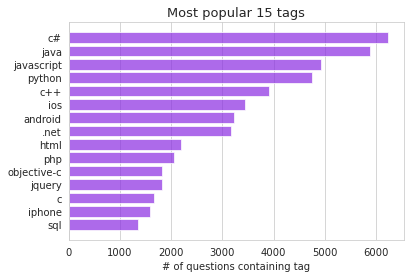

In [21]:
# Plotting the 10 most popular tags
plot_numb_popular_tags(popular_tags, 15)

In [22]:
def filter_popular_tags(df,tags,pop_tags):
    '''
    Returns a dataframe with filtered tags:
    it keeps only tags in the list pop_tags and
    removes the rest of the tags. Removes rows without
    popular tags.

    Parameters:
        - df: pd.DataFrame
        - pop_tags: list of str
            list of popular tags to keep.
        - tags: str
            label of the tags column in df.
    '''
    # Exploding series of tags as rows (preserves the index)
    tags_series = df[tags].explode()

    # Boolean of preceding series: True if tag is popular
    is_pop_tag = tags_series.isin(pop_tags)

    # Series of tags for which True
    pop_tags_series = tags_series[is_pop_tag]

    # Groupby of this series to go back to a list of tags
    pop_tags_series = pop_tags_series.groupby(by=pop_tags_series.index).agg(list)

    # Merge with dataframe to keep only popular tags
    pop_tags_df = pd.merge(left=df, 
                           right=pop_tags_series, 
                           how='right', 
                           left_index=True, 
                           right_index=True, 
                           suffixes=('_old',None))
    pop_tags_df.drop(columns=[tags+'_old'], inplace=True)

    return pop_tags_df

We now filter our dataset to keep only popular tags

In [23]:
print(f'Dataset shape before filter : {df.shape}')

# Filtering popular tags
popular_tags = list(popular_tags.keys())
df = filter_popular_tags(df,'Tags',popular_tags)

print(f'Dataset shape after filter : {df.shape}')

Dataset shape before filter : (50000, 6)
Dataset shape after filter : (42303, 6)


## Creating target columns

We now encode the tags into columns: one column for each one of the popular tags. In each column there are binary values: 1 if the corresponding tag is in the document and 0 otherwise.

In [24]:
print(popular_tags)

['c#', 'java', 'javascript', 'python', 'c++', 'ios', 'android', '.net', 'html', 'php', 'objective-c', 'jquery', 'c', 'iphone', 'sql', 'asp.net', 'css', 'linux', 'node.js', 'performance', 'spring', 'windows', 'swift', 'xcode', 'ruby-on-rails', 'mysql', 'json', 'sql-server', 'multithreading', 'asp.net-mvc', 'ruby', 'database', 'wpf', 'unit-testing', 'macos', 'arrays', 'c++11', 'django']


In [25]:
# popular_tags = ['c#','java','javascript','python','c++','ios','android','.net','html','php']  

In [26]:
mlb = MultiLabelBinarizer(classes=popular_tags)
mlb.fit([popular_tags])

MultiLabelBinarizer(classes=['c#', 'java', 'javascript', 'python', 'c++', 'ios',
                             'android', '.net', 'html', 'php', 'objective-c',
                             'jquery', 'c', 'iphone', 'sql', 'asp.net', 'css',
                             'linux', 'node.js', 'performance', 'spring',
                             'windows', 'swift', 'xcode', 'ruby-on-rails',
                             'mysql', 'json', 'sql-server', 'multithreading',
                             'asp.net-mvc', ...])

In [27]:
mlb.classes_

array(['c#', 'java', 'javascript', 'python', 'c++', 'ios', 'android',
       '.net', 'html', 'php', 'objective-c', 'jquery', 'c', 'iphone',
       'sql', 'asp.net', 'css', 'linux', 'node.js', 'performance',
       'spring', 'windows', 'swift', 'xcode', 'ruby-on-rails', 'mysql',
       'json', 'sql-server', 'multithreading', 'asp.net-mvc', 'ruby',
       'database', 'wpf', 'unit-testing', 'macos', 'arrays', 'c++11',
       'django'], dtype=object)

In [28]:
# Appending columns of binarized tags
col_names = ['tag_'+tag for tag in mlb.classes_]
df[col_names] = mlb.transform(df['Tags'])

In [29]:
df.sample(4)

,Title,Body,Score,ViewCount,AnswerCount,Tags,tag_c#,tag_java,tag_javascript,tag_python,...,tag_multithreading,tag_asp.net-mvc,tag_ruby,tag_database,tag_wpf,tag_unit-testing,tag_macos,tag_arrays,tag_c++11,tag_django
Id,,,,,,,,,,,,,,,,,,,,,
30089675,Clustering cosine similarity matrix,<p>A few questions on stackoverflow mention th...,20,24818,1,[python],0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
48887128,Running Selenium Tests in Chrome (Headless mod...,<p>Is it possible to run Selenium C# tests on ...,7,7310,3,[c#],1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47441027,Pessimistic locking vs Serializable transactio...,<p>I kinda understand the purpose of entity lo...,20,5813,2,"[java, database]",0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
29342757,PyYaml - Dump unicode with special characters ...,<p>I'm working with yaml files that have to be...,24,16528,2,[python],0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Processing title and body text

In [30]:
def remove_code(text):
    """
    Removes "<code> some text </code>" from a text.
    or "<script> some text </script>"

    Parameters
        - text : str
    """
    soup = BeautifulSoup(text,'lxml')
    code_to_remove = soup.findAll('code')
    for code in code_to_remove:
        code.replace_with(' ')
        
    code_to_remove = soup.findAll('script')
    for code in code_to_remove:
        code.replace_with(' ')

    return str(soup)

We now add stopwords to the default english tokenizer stopword set. Our set of stopwords can be find in this [github repository](#https://github.com/Alir3z4/stop-words/blob/master/english.txt).

In [31]:
# Instantiating language model, english
nlp = spacy.load("en_core_web_sm")

# Importing stopwords
with open('./stopwords/stopwords.txt') as file:
    my_stopwords = {line.rstrip() for line in file}

# print # of stopwords
print(f'The default spacy stopwords set contains {len(nlp.Defaults.stop_words)} stopwords.')
print(f'This file contains {len(my_stopwords)} stopwords.')
print('The first 10 stopwords are:')
print(list(my_stopwords)[:10])


The default spacy stopwords set contains 326 stopwords.
This file contains 1298 stopwords.
The first 10 stopwords are:
['sensible', 'werent', 'down', 'overall', 'thus', 'perhaps', 'strongly', 'front', 'hither', 'width']


In [32]:
# Adding my_stopwords to spacy stopwords
nlp.Defaults.stop_words = nlp.Defaults.stop_words.union(my_stopwords)

# Checking new size of stopwords
print(f'we use {len(nlp.Defaults.stop_words)} in total.')

we use 1317 in total.


In [33]:
def clean(text,tokenize=False,strict=False, **kwargs):
    """
    Returns a dictionnary with keys 'text' or 'tokens', where
    'tokens' corresponds tothe list of lemmatized tokens from
    the string text. Ommiting stopwords and punctuation, and the text is
    the joint text.

    Parameters:
        - text: str
        - tokenize: bool
            If True returns list of tokens, if False returns string.
        - strict: bool
            If true only keeps nouns
    """


    # Removing <code>some code</code>
    clean_txt = remove_code(text)

    # Removing HTML tags
    soup = BeautifulSoup(clean_txt, features='html.parser')
    clean_txt = soup.get_text()

    # Removing new line character: \n
    clean_txt = clean_txt.replace('\n', ' ')

    # Removing unicode characters
    clean_txt = clean_txt.encode("ascii", "ignore").decode()
    
    # Removing digits
    clean_txt = ''.join(char for char in clean_txt if not char.isdigit())

    # Replacing 'c ++' and 'c #' for 'c++' and 'c#' and others
    clean_txt = clean_txt.replace('c ++', 'c++')
    clean_txt = clean_txt.replace('c #', 'c#')
    clean_txt = clean_txt.replace('C ++', 'c++')
    clean_txt = clean_txt.replace('C #', 'c#')
    clean_txt = clean_txt.replace('C#', 'c#')
    clean_txt = clean_txt.replace('C ++', 'c++')

    # Adding special case rule
    special_case = [{ORTH: "c#"}] 
    nlp.tokenizer.add_special_case("c#", special_case)
    special_case = [{ORTH: ".net"}] 
    nlp.tokenizer.add_special_case(".net", special_case)
    special_case = [{ORTH: "objective-c"}] 
    nlp.tokenizer.add_special_case("objective-c", special_case)
    special_case = [{ORTH: "asp.net"}]
    nlp.tokenizer.add_special_case("asp.net", special_case)
    special_case = [{ORTH: "node.js"}]
    nlp.tokenizer.add_special_case("node.js", special_case)
    special_case = [{ORTH: "ruby-on-rails"}]
    nlp.tokenizer.add_special_case("ruby-on-rails", special_case)    
    special_case = [{ORTH: "sql-server"}] 
    nlp.tokenizer.add_special_case("sql-server", special_case)    
    special_case = [{ORTH: "unit-testing"}] 
    nlp.tokenizer.add_special_case("unit-testing", special_case)
  
    # Tokenize with spacy
    doc = nlp(clean_txt)

    # Tokenize properties
    if strict == True:
        tokens = [token.lemma_.lower() for token in doc
                    if token.pos_ in ['NOUN', 'PROPN', 'VERB'] and
                        (not (token.is_stop or 
                              token.is_punct or
                              token.is_space
                              )
                        )
                 ]    
    else:
        tokens = [token.lemma_.lower() for token in doc
                    if not (token.is_stop or 
                            token.is_punct or
                            token.is_space
                            )
                 ]

    clean_txt = ' '.join(tokens)
    
    # Ask if return text or tokens
    if tokenize == True:
        result = tokens
    else:
        result = clean_txt

    # Option for list of entities in output
    if 'ent' in kwargs:
        result = {'output':result, 'ents': doc.ents}

    return result

In [34]:
clean("Hi i'm currently studying c++, c#, sometimes c # and i love .net", tokenize=False, strict=False)

'hi currently study c++ c# c# love .net'

Let us test this function with two examples:

**Example 1:**

In [35]:
# Sample text
sample_text = df.loc[11, 'Body']
sample_text

'<p>Given a specific <code>DateTime</code> value, how do I display relative time, like:</p>\n<ul>\n<li><code>2 hours ago</code></li>\n<li><code>3 days ago</code></li>\n<li><code>a month ago</code></li>\n</ul>\n'

In [36]:
clean(sample_text, tokenize=False, strict=False)

'give specific value display relative time like'

In [37]:
print(clean(sample_text, tokenize=True, strict=False))

['give', 'specific', 'value', 'display', 'relative', 'time', 'like']


Tokens:

Using the `strict=True` condition

In [38]:
clean(sample_text, tokenize=False, strict=True)

'give value display time'

In [39]:
print(clean(sample_text, tokenize=True, strict=True))

['give', 'value', 'display', 'time']


Entities: (NER)

In [40]:
clean(sample_text, tokenize=True, ent=True, strict=False)['ents']

()

**Example 3** An example with code on the body

In [41]:
sample_text = df.loc[37242063, 'Body']
sample_text

'<p>I\'m using Odoo 8 version.</p>\n\n<p>I have created a new model called <em>enquiry_customer_date</em></p>\n\n<p>In that model, I have set following four fields. </p>\n\n<ul>\n<li>partner_id (many2one), </li>\n<li>enquiry_date (date),</li>\n<li>file_name (char) and</li>\n<li>excel_file (binary)</li>\n</ul>\n\n<p>I have given mention model one2many relationship with <em>res.partner</em> model</p>\n\n<p>I have used below code for display records.</p>\n\n<pre><code>&lt;field name="enquiry_from_customer_ids"&gt;\n    &lt;tree string="Enquiry Lines"&gt;\n        &lt;field name="enquiry_date"/&gt;\n        &lt;field name="file_name" invisible="1"/&gt;\n        &lt;field name="excel_file" filename="file_name"/&gt;\n    &lt;/tree&gt;    \n&lt;/field&gt;\n</code></pre>\n\n<p>This will display correct file name in list view.</p>\n\n<p><strong>Face Problem:</strong></p>\n\n<p>When I download link, it stores with file name = base64 with <em>.bin</em> extension.</p>\n\n<p><strong>Question</stron

In [42]:
clean(sample_text, tokenize=False,strict=False)

'odoo version create new model call enquiry_customer_date model set follow field partner_id manyone enquiry_date date file_name char excel_file binary give mention model onemany relationship res.partner model code display record display correct file list view face problem download link store file = base .bin extension question work download link uploaded file extension onemany field update try @danidee answer system configuration parameter treeview listview onemany field output expect output file download openerp_customization_needed.txt'

In [43]:
clean(sample_text, tokenize=False,strict=True)

'odoo version create model call enquiry_customer_date model set follow field partner_id manyone enquiry_date date file_name char binary give mention model onemany relationship res.partner model code display record display file list view face problem download link store file = base .bin extension question work download link file extension onemany field update try @danidee answer system configuration parameter treeview listview onemany field output expect output file download openerp_customization_needed.txt'

## Processing text

We first create a column of text concatenating the title and the body. And then we process that column with our `clean` function to finally process the text.

In [44]:
df.head()

,Title,Body,Score,ViewCount,AnswerCount,Tags,tag_c#,tag_java,tag_javascript,tag_python,...,tag_multithreading,tag_asp.net-mvc,tag_ruby,tag_database,tag_wpf,tag_unit-testing,tag_macos,tag_arrays,tag_c++11,tag_django
Id,,,,,,,,,,,,,,,,,,,,,
4,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot...,792,70052,14,[c#],1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,1644,196587,41,[c#],1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,698,274233,27,[html],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,351,67159,24,[performance],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,175,15797,9,"[c++, c]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Concatenating title and body
df.insert(0,'text',df['Title'] + ' ' + df['Body'])

Let us see the lengths of the text to be processed and based on the distribution of the lengths, restrict ourselves to posts up to a certain length of characters.

In [46]:
# Statistics for the length of text (title+body)
df.text.str.len().describe()

count    42303.000000
mean      1744.026925
std       2111.668159
min         57.000000
25%        662.000000
50%       1143.000000
75%       2027.000000
max      37387.000000
Name: text, dtype: float64

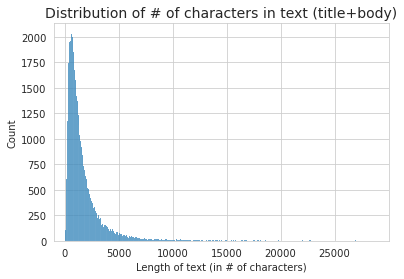

In [47]:
# Plotting distribution of length of text
h = sns.histplot(df.text.str.len())
plt.title('Distribution of # of characters in text (title+body)', size=14)
plt.xlabel('Length of text (in # of characters)')
h.set_xlim(-1000,30000)
h.set_xticks(range(0,30000,5000))
plt.show()

To keep a set of documents which is more uniform, we keep only text with a number of characters between 1 and 5000.

In [48]:
df.loc[df.text.str.len() <= 5000].shape


(40166, 45)

In [49]:
shape_before = df.shape
print(f'Shape of dataset before filter: {shape_before}')
df = df.loc[df.text.str.len() <= 5000]
shape_after = df.shape
print(f'Shape of dataset after filter: {shape_after}')
print(f'Number of deleted rows: {shape_before[0] - shape_after[0]}')

Shape of dataset before filter: (42303, 45)
Shape of dataset after filter: (40166, 45)
Number of deleted rows: 2137


In [50]:
# Cleaning/tokenizing the text
start = time.time()
processed_text = df['text'].apply(lambda txt:clean(txt, tokenize=False, strict=True))
end = time.time()
df.insert(0,'processed_text', processed_text)
total_time = end - start
print(f'Total time to process text: {round(total_time,2)} seconds. (= {round(total_time/60,2)} minutes)')

Total time to process text: 1233.7 seconds. (= 20.56 minutes)


In [51]:
# Previewing dataframe
df.head()

,processed_text,text,Title,Body,Score,ViewCount,AnswerCount,Tags,tag_c#,tag_java,...,tag_multithreading,tag_asp.net-mvc,tag_ruby,tag_database,tag_wpf,tag_unit-testing,tag_macos,tag_arrays,tag_c++11,tag_django
Id,,,,,,,,,,,,,,,,,,,,,
4,convert decimal double c# want assign variable...,How to convert Decimal to Double in C#? <p>I w...,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot...,792,70052,14,[c#],1,0,...,0,0,0,0,0,0,0,0,0,0
11,calculate time c# give value display time,Calculate relative time in C# <p>Given a speci...,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,1644,196587,41,[c#],1,0,...,0,0,0,0,0,0,0,0,0,0
13,determine user timezone way web server determi...,Determine a user's timezone <p>Is there a stan...,Determine a user's timezone,<p>Is there a standard way for a web server to...,698,274233,27,[html],0,0,...,0,0,0,0,0,0,0,0,0,0
19,way value look way obtain value challenge way ...,What is the fastest way to get the value of π?...,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,351,67159,24,[performance],0,0,...,0,0,0,0,0,0,0,0,0,0
25,use c socket api c++ z os have issue get c soc...,How to use the C socket API in C++ on z/OS <p>...,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,175,15797,9,"[c++, c]",0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# Last check for missing values
df.isna().sum()

processed_text        0
text                  0
Title                 0
Body                  0
Score                 0
ViewCount             0
AnswerCount           0
Tags                  0
tag_c#                0
tag_java              0
tag_javascript        0
tag_python            0
tag_c++               0
tag_ios               0
tag_android           0
tag_.net              0
tag_html              0
tag_php               0
tag_objective-c       0
tag_jquery            0
tag_c                 0
tag_iphone            0
tag_sql               0
tag_asp.net           0
tag_css               0
tag_linux             0
tag_node.js           0
tag_performance       0
tag_spring            0
tag_windows           0
tag_swift             0
tag_xcode             0
tag_ruby-on-rails     0
tag_mysql             0
tag_json              0
tag_sql-server        0
tag_multithreading    0
tag_asp.net-mvc       0
tag_ruby              0
tag_database          0
tag_wpf               0
tag_unit-testing

# Export processed data

In [55]:
# Export processed data
path = './data/'
filename = 'processed_data_v011.csv'
# Export smaller sample
df_sample = df.sample(10000)
filename_sample ='processed_data_v011_sample.csv'

df.to_csv(path + filename)
df_sample.to_csv(path + filename_sample)